# WTI Price Modelling

In [263]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns
import numba as nb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [264]:
data = pd.read_csv('dataset.csv')

scaler = StandardScaler(with_mean=True)
scaler = StandardScaler(with_mean=True)

train_test_split_date = '2024-06-01'

In [265]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %,DXY,Geopolitical Risk Index,US 10-year Treasury Yield,VIX,WTI-Brent Spread
0,7/7/2025,67.16,65.92,67.18,65.55,49710,0.0190,97.38,207.74,4.360,17.790,-3.100
1,6/7/2025,65.91,65.82,66.18,65.68,9560,-0.0087,96.96,207.74,4.324,17.635,-3.125
2,4/7/2025,66.49,67.13,67.16,66.05,56220,-0.0076,96.96,207.74,4.328,17.480,-3.150
3,3/7/2025,67.00,67.50,67.58,66.53,220440,-0.0067,97.18,207.74,4.346,16.380,-3.160
4,2/7/2025,67.45,65.56,67.58,65.23,265200,0.0306,96.78,207.74,4.282,16.640,-3.110


In [266]:
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data.set_index('Date', inplace=True)

data = data.sort_values('Date', ascending=True)

# XGBoost Model

In [267]:
xgb_df = data.copy()

Feature Engineering

In [268]:
xgb_df['Price_lag1'] = xgb_df['Price'].shift(1)

xgb_df['Price_SMA_5'] = xgb_df['Price'].rolling(window=5).mean().shift(1)
xgb_df['Price_SMA_10'] = xgb_df['Price'].rolling(window=10).mean().shift(1)
xgb_df['Price_SMA_20'] = xgb_df['Price'].rolling(window=20).mean().shift(1)

def compute_rsi(xgb_df, window=14):
  delta = xgb_df['Price'].diff()
  gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
  loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
  rs = gain / loss
  return 100 - (100 / (1 + rs))

xgb_df['Price_RSI_14'] = compute_rsi(xgb_df, window=14).shift(1)

xgb_df['Price_Rolling_Std_20'] = xgb_df['Price'].rolling(window=20).std().shift(1)
xgb_df['Upper_Band'] = xgb_df['Price_SMA_20'] + (xgb_df['Price_Rolling_Std_20'] * 2)
xgb_df['Lower_Band'] = xgb_df['Price_SMA_20'] - (xgb_df['Price_Rolling_Std_20'] * 2)

xgb_df['Price_vs_SMA_5'] = xgb_df['Price_lag1'] - xgb_df['Price_SMA_5']
xgb_df['Price_vs_SMA_10'] = xgb_df['Price_lag1'] - xgb_df['Price_SMA_10']
xgb_df['Price_vs_SMA_20'] = xgb_df['Price_lag1'] - xgb_df['Price_SMA_20']

xgb_df['Price_vs_Upper_Band'] = xgb_df['Price_lag1'] - xgb_df['Upper_Band']
xgb_df['Price_vs_Lower_Band'] = xgb_df['Price_lag1'] - xgb_df['Lower_Band']

exogenous_features_xgb = [
    'Price_SMA_5', 'Price_SMA_10', 'Price_SMA_20', 'Price_RSI_14',
    'Upper_Band', 'Lower_Band', 'Price_Rolling_Std_20',
    'Price_vs_SMA_5', 'Price_vs_SMA_10', 'Price_vs_SMA_20',
    'Price_vs_Upper_Band', 'Price_vs_Lower_Band'
]

Train/Test Split

In [269]:
xgb_df = xgb_df.dropna()

train_split = xgb_df[xgb_df.index < train_test_split_date]
test_split = xgb_df[xgb_df.index >= train_test_split_date]

train_split.loc[:, exogenous_features_xgb] = scaler.fit_transform(train_split[exogenous_features_xgb])
test_split.loc[:, exogenous_features_xgb] = scaler.transform(test_split[exogenous_features_xgb])


X_train_xgb = train_split[exogenous_features_xgb]
y_train_xgb = train_split['Price']
X_test_xgb = test_split[exogenous_features_xgb]
y_test_xgb = test_split['Price']

Model

In [270]:
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.05, max_depth=5, random_state=42, n_jobs=-1)
xgb_model.fit(X_train_xgb, y_train_xgb)

predictions_xgb = xgb_model.predict(X_test_xgb)

Evaluation

XGBoost Mean Squared Error: 3.796654269046938
XGBoost Root Mean Squared Error: 1.9485005181028148
XGBoost R-squared: 0.8835001307859566


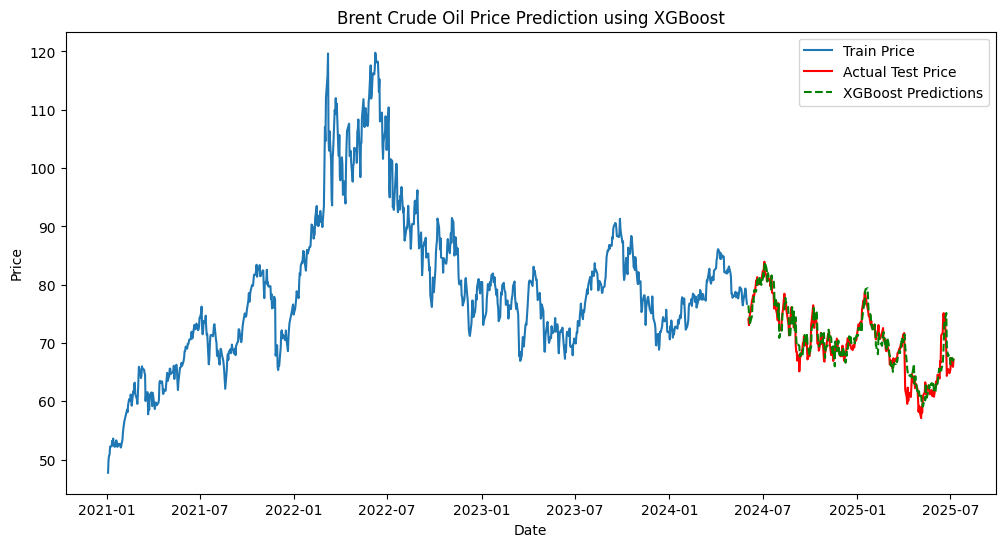

In [271]:
mse_xgb = mean_squared_error(y_test_xgb, predictions_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test_xgb, predictions_xgb)

print(f'XGBoost Mean Squared Error: {mse_xgb}')
print(f'XGBoost Root Mean Squared Error: {rmse_xgb}')
print(f'XGBoost R-squared: {r2_xgb}')

plt.figure(figsize=(12, 6))
plt.plot(train_split.index, train_split['Price'], label='Train Price')
plt.plot(test_split.index, y_test_xgb, label='Actual Test Price', color='red')
plt.plot(test_split.index, predictions_xgb, label='XGBoost Predictions', color='green', linestyle='--')
plt.title('Brent Crude Oil Price Prediction using XGBoost')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# Monte Carlo Simulation

In [272]:
def calculate_payoff(curr_price):
  return curr_price - 60

In [273]:
def run_occurence(
    days: int,
    initial_df: pd.DataFrame,
    model,
    features: list[str],
    scaler,
    randomize: bool = False,
    seed: int | None = None,
    implied_volatility: float | None = None,
):
    if 'Date' not in initial_df.columns:
      initial_df.reset_index(inplace=True)

    df = initial_df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", inplace=True)

    if randomize:
        np.random.seed(seed)
        if implied_volatility is None:
          vol = np.log(df["Price"] / df["Price"].shift(1)).std()
        else:
          vol = implied_volatility / days ** 0.5

    # ---------- helper to build one feature row ----------
    def build_row(prices: pd.Series) -> dict:
        hist = prices
        row  = {}

        row["Price_SMA_5"]   = hist.rolling(5).mean().iloc[-1]
        row["Price_SMA_10"]  = hist.rolling(10).mean().iloc[-1]
        row["Price_SMA_20"]  = hist.rolling(20).mean().iloc[-1]
        row["Price_Rolling_Std_20"] = hist.rolling(20).std().iloc[-1]

        sma20, std20 = row["Price_SMA_20"], row["Price_Rolling_Std_20"]
        row["Upper_Band"] = None if pd.isna(sma20) else sma20 + 2 * std20
        row["Lower_Band"] = None if pd.isna(sma20) else sma20 - 2 * std20

        if len(hist) >= 15:
            d  = hist.diff()
            g  = d.clip(lower=0).rolling(14).mean().iloc[-1]
            l  = (-d.clip(upper=0)).rolling(14).mean().iloc[-1]
            rs = np.inf if l == 0 else g / l
            row["Price_RSI_14"] = 100 - 100 / (1 + rs)
        else:
            row["Price_RSI_14"] = np.nan

        lag = hist.iloc[-1]
        row["Price_lag1"] = lag
        row["Price_vs_SMA_5"]   = lag - row["Price_SMA_5"]
        row["Price_vs_SMA_10"]  = lag - row["Price_SMA_10"]
        row["Price_vs_SMA_20"]  = lag - row["Price_SMA_20"]
        row["Price_vs_Upper_Band"] = lag - row["Upper_Band"]
        row["Price_vs_Lower_Band"] = lag - row["Lower_Band"]
        return row
    # -----------------------------------------------------

    for _ in range(days):
        feat_row = build_row(df["Price"])
        X_next   = pd.DataFrame([feat_row])[features]

        # skip until all needed indicators available
        if X_next.isnull().any(axis=None):
            break

        # ----------  SCALE before predict  ----------
        X_next_scaled = scaler.transform(X_next)
        next_price    = model.predict(X_next_scaled)[0]

        if randomize:
            next_price *= np.exp(np.random.normal(0, vol))

        new_date          = df.index[-1] + pd.Timedelta(days=1)
        feat_row["Price"] = next_price
        df = pd.concat([df, pd.DataFrame(feat_row, index=[new_date])])

    return df.reset_index()


Optimized Model

In [274]:
feature_means = scaler.mean_.astype(np.float64)
feature_stds  = scaler.scale_.astype(np.float64)
booster       = xgb_model.get_booster()

@nb.njit
def build_feature_matrix(prices0, days,
                         mu_g, mu_l,
                         sma5, sma10, sma20, var20):
    """Return (feature_matrix, placeholder_prices)."""
    n_feat = 12
    feats  = np.empty((days, n_feat), np.float64)
    w5, w10, w20 = prices0[-5:].copy(), prices0[-10:].copy(), prices0[-20:].copy()
    i5 = i10 = i20 = 0
    last_p = prices0[-1]

    for t in range(days):
        std20 = np.sqrt(var20)
        upper = sma20 + 2 * std20
        lower = sma20 - 2 * std20
        rsi14 = 100 - 100 / (1 + mu_g / mu_l)

        feats[t, 0]  = sma5
        feats[t, 1]  = sma10
        feats[t, 2]  = sma20
        feats[t, 3]  = rsi14
        feats[t, 4]  = std20
        feats[t, 5]  = upper
        feats[t, 6]  = lower
        feats[t, 7]  = last_p - sma5
        feats[t, 8]  = last_p - sma10
        feats[t, 9]  = last_p - sma20
        feats[t,10]  = last_p - upper
        feats[t,11]  = last_p - lower

        # ========== update windows WITH PLACEHOLDER 0 (real price later) ==
        new_p = 0.0
        feats[t, :]  # stored; will scale later

        sma5  += (new_p - w5[i5])  / 5.0;   w5[i5]  = new_p;   i5  = (i5+1)%5
        sma10 += (new_p - w10[i10]) /10.0;  w10[i10]= new_p;   i10 = (i10+1)%10
        old20 = w20[i20]
        sma20 += (new_p - old20) / 20.0
        var20 += (new_p - sma20)*(new_p - sma20) - (old20 - sma20)*(old20 - sma20)
        w20[i20] = new_p; i20 = (i20+1)%20

        delta = new_p - last_p
        gain  = max(delta,0.0); loss = max(-delta,0.0)
        alpha = 1/14.0
        mu_g = (1-alpha)*mu_g + alpha*gain
        mu_l = (1-alpha)*mu_l + alpha*loss if mu_l!=0 else 1e-8
        last_p = new_p
    return feats

# --------------------------- 4. high-level wrapper -----------------------
def run_brent_sim(
    initial_df: pd.DataFrame,
    days: int,
    booster,
    scaler,
    implied_vol_annual: float | None = None,
    randomize: bool = False,
    seed: int | None = None,
) -> pd.DataFrame:
    """Return historical + simulated Brent prices for `days` steps."""
    df0 = initial_df.copy()
    if 'Date' not in df0.columns:
        df0.reset_index(inplace=True)
    df0['Date'] = pd.to_datetime(df0['Date'])
    df0.sort_values('Date', inplace=True)
    prices = df0['Price'].values.astype(np.float64)

    # warm-start RSI means
    d14 = np.diff(prices[-15:])
    mu_g = d14[d14>0].mean() if (d14>0).any() else 0.0
    mu_l = (-d14[d14<0]).mean() if (d14<0).any() else 1e-8

    sma5, sma10, sma20 = prices[-5:].mean(), prices[-10:].mean(), prices[-20:].mean()
    var20 = prices[-20:].var(ddof=0)

    # build raw feature matrix (unscaled) with numba
    raw_feats = build_feature_matrix(prices, days, mu_g, mu_l,
                                     sma5, sma10, sma20, var20)

    # scale whole matrix once
    feat_mat = (raw_feats - feature_means) / feature_stds

    # XGBoost batch prediction
    preds = booster.inplace_predict(feat_mat)

    # optional Monte-Carlo shocks
    if randomize:
        np.random.seed(seed)
        sig_d = (implied_vol_annual/np.sqrt(days) if implied_vol_annual
                 else np.log(prices[1:]/prices[:-1]).std(ddof=0))
        preds *= np.exp(np.random.normal(0., sig_d, size=days))

    start_date  = df0['Date'].iloc[-1] + pd.Timedelta(days=1)
    future_dates = pd.date_range(start_date, periods=days)
    sim_df       = pd.DataFrame({'Date': future_dates, 'Price': preds})

    return pd.concat([df0[['Date', 'Price']], sim_df], ignore_index=True)


TypeError: float() argument must be a string or a real number, not 'Timestamp'

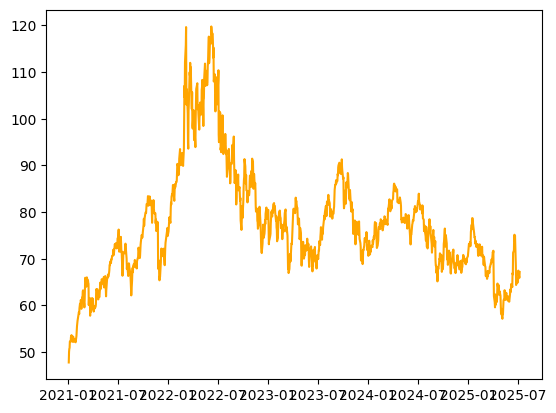

In [278]:
implied_volatility = 0.305

# simulation_results_df = run_occurence(days=180, randomize=True, seed=32, initial_df = xgb_df, model=xgb_model,scaler=scaler, features=exogenous_features_xgb, implied_volatility = implied_volatility)
simulation_results_df = run_brent_sim(days=180, randomize=True, seed=32, initial_df = xgb_df, booster=booster, scaler=scaler, implied_vol_annual=implied_volatility)

plt.plot(simulation_results_df['Price'], label='Simulated Price')
plt.plot(xgb_df['Price'], label='Actual Price')
plt.title('Simulated vs Actual Brent Crude Oil Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

print(simulation_results_df.tail(94))

In [ ]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [ ]:
xgb_df.head()

In [ ]:
simulated_final_prices = []


num_of_sims = 100

seed_salt = np.random.randint(0, 10*num_of_sims)

cmap = get_cmap(num_of_sims)

for i in range(num_of_sims):
  curr_df = run_occurence(days=180, randomize=True, seed=i+seed_salt, initial_df = xgb_df, model=xgb_model,scaler=scaler, features=exogenous_features_xgb)
  simulated_final_prices.append(curr_df['Price'].iloc[-1])
  print(i,curr_df['Price'].iloc[-1])
  # plt.plot(curr_df['Price'], label=f'Simulated Price {i+1}', c=cmap(i))

# plt.plot(xgb_df.loc['Date' > '2024-06-01','Price'], label='Actual Price', color='red')
# plt.title('Simulated vs Actual WTI Crude Oil Price')
# plt.xlabel('Date')
# plt.ylabel('Price')
# plt.legend()
# plt.show()

In [ ]:
print('Average: ', np.mean(simulated_final_prices))
print('Max: ', np.max(simulated_final_prices))
print('Min: ', np.min(simulated_final_prices))
print('Median: ', np.median(simulated_final_prices))

plt.hist(simulated_final_prices, bins=20, alpha=0.7)
plt.title('Distribution of Simulated Final Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()